# Speech Emotion Recognition using the RAVDESS AND TESS dataset

Importing Librosa library(A python package) for extracting important features of the audio like the pitch,tone.

In [1]:
!pip install librosa
!pip install resampy


Loading one audio file from the drive using librosa.
Librosa loads the audio file as a floating point time series.

In [2]:
import librosa
from librosa import display

data, sampling_rate = librosa.load('D:/staffs/Msc/code/MODEL/Ravtess/03-01-01-01-01-01-03.wav')

Plotting the audio file which was just loaded by librosa using waveplot function of librosa.This Function Plots the amplitude envelope of a waveform.

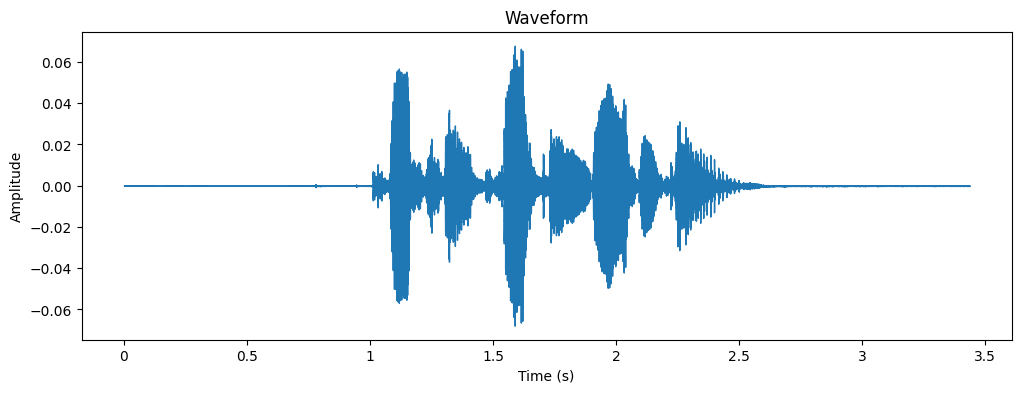

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Assuming 'data' contains the audio time series and 'sampling_rate' contains the sampling rate
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sampling_rate)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()


# Load all files

We will create our numpy array extracting Mel-frequency cepstral coefficients (MFCCs), while the classes to predict will be extracted from the name of the file (see the introductory section of this notebook to see the naming convention of the files of this dataset).

In [4]:
import time
import numpy as np
import os
path = 'D:/staffs/Msc/code/MODEL/Ravtess'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 122.35863041877747 seconds ---


In [5]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [6]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((1440, 40), (1440,))

In [7]:
# Saving joblib files to not load them again with the loop above

import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = 'D:/staffs/Msc/code/MODEL'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [8]:
# Loading saved models
import joblib
X = joblib.load('D:/staffs/Msc/code/MODEL/X.joblib')
y = joblib.load('D:/staffs/Msc/code/MODEL/y.joblib')

# Decision Tree Classifier

To make a first attempt in accomplishing this classification task I chose a decision tree:

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [10]:
from sklearn.tree import DecisionTreeClassifier

In [11]:
dtree = DecisionTreeClassifier()

In [12]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [13]:
predictions = dtree.predict(X_test)

In [14]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.21      0.24      0.23        25
           1       0.54      0.44      0.48        62
           2       0.31      0.29      0.30        70
           3       0.31      0.31      0.31        70
           4       0.53      0.53      0.53        58
           5       0.35      0.34      0.35        67
           6       0.35      0.34      0.34        65
           7       0.30      0.39      0.34        59

    accuracy                           0.37       476
   macro avg       0.36      0.36      0.36       476
weighted avg       0.37      0.37      0.37       476



# Neural network

In [15]:
import numpy as np
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [16]:
x_traincnn.shape, x_testcnn.shape

((964, 40, 1), (476, 40, 1))

In [17]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Input, Flatten, Dropout, Activation, Conv1D, MaxPooling1D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop  # Use the current optimizer

model = Sequential()

model.add(Conv1D(64, 5, padding='same', input_shape=(40, 1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(256, 5, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))

# Use the current RMSprop optimizer
opt = RMSprop(learning_rate=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 40, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 2, 256)         │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         4,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,672 (819.03 KB)

 Trainable params: 209,672 (819.03 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [20]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1346 - loss: 6.5728 - val_accuracy: 0.1555 - val_loss: 2.5177
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1044 - loss: 4.7851 - val_accuracy: 0.1576 - val_loss: 2.0679
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1418 - loss: 4.0050 - val_accuracy: 0.1618 - val_loss: 2.4336
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1549 - loss: 3.6540 - val_accuracy: 0.1513 - val_loss: 2.3211
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1237 - loss: 3.2155 - val_accuracy: 0.1618 - val_loss: 2.1555
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1630 - loss: 2.8756 - val_accuracy: 0.2290 - val_loss: 2.0962
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1705 - loss: 2.7596 - val_accuracy: 0.1996 - val_loss: 2.0375
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2060 - loss: 2.5491 - val_accuracy: 0.2710 - v

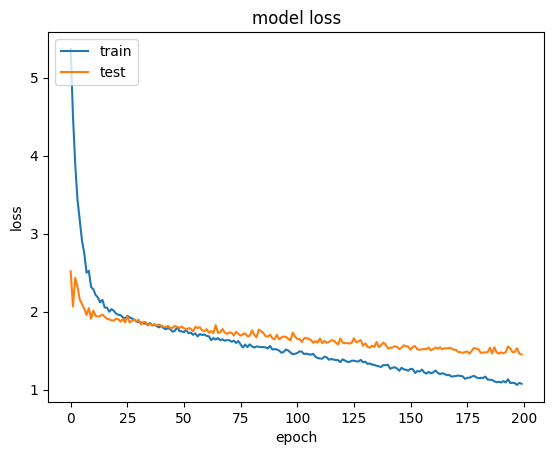

In [21]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

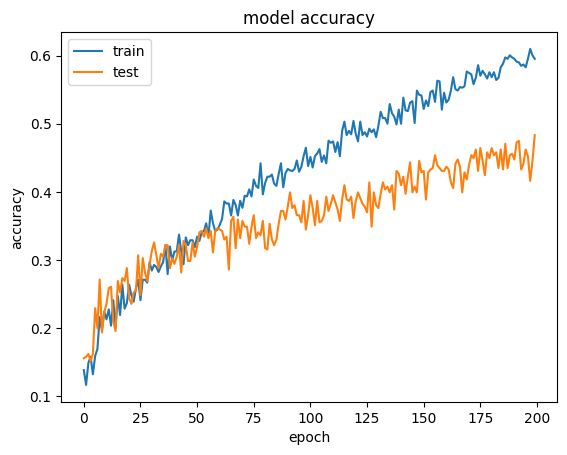

In [22]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
# Assuming x_testcnn is your test data
predictions = model.predict(x_testcnn)
predicted_classes = np.argmax(predictions, axis=1)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [24]:
predictions

array([[1.67724580e-01, 2.82396823e-01, 1.39950499e-01, ...,
        4.78692353e-02, 8.92758518e-02, 6.58403039e-02],
       [4.70294477e-03, 1.49862317e-04, 2.10882470e-01, ...,
        2.64023691e-01, 1.27654180e-01, 2.81616449e-01],
       [1.08877495e-01, 1.11977011e-01, 2.25502327e-01, ...,
        3.03906947e-02, 2.00211167e-01, 8.39594156e-02],
       ...,
       [1.04003139e-01, 1.23178691e-01, 2.44722702e-02, ...,
        2.48612702e-01, 1.51810601e-01, 1.74125955e-01],
       [1.29368812e-01, 4.62404609e-01, 1.75550371e-01, ...,
        2.63070241e-02, 8.87577310e-02, 5.40401135e-03],
       [2.99377739e-01, 2.56383985e-01, 5.05927205e-02, ...,
        2.17097811e-02, 2.88655199e-02, 1.13034509e-02]], dtype=float32)

In [25]:
y_test

array([1, 3, 3, 0, 3, 5, 7, 7, 6, 1, 3, 1, 6, 5, 1, 7, 4, 4, 2, 2, 6, 5,
       6, 3, 4, 4, 3, 2, 0, 1, 5, 6, 5, 3, 3, 4, 0, 1, 6, 0, 2, 6, 2, 1,
       4, 7, 0, 1, 7, 2, 6, 3, 7, 6, 3, 5, 2, 6, 5, 1, 3, 7, 7, 1, 7, 1,
       7, 0, 5, 6, 4, 2, 4, 0, 2, 2, 6, 2, 3, 3, 2, 0, 3, 6, 7, 6, 1, 0,
       0, 2, 2, 5, 5, 3, 2, 2, 2, 6, 5, 1, 4, 6, 4, 1, 4, 3, 7, 2, 7, 4,
       2, 4, 2, 2, 5, 4, 6, 3, 5, 5, 1, 2, 4, 0, 5, 3, 6, 3, 1, 4, 4, 5,
       3, 4, 1, 3, 7, 1, 7, 7, 3, 4, 4, 1, 0, 3, 2, 4, 5, 5, 1, 5, 6, 3,
       4, 3, 5, 1, 3, 1, 5, 1, 4, 3, 5, 0, 3, 1, 1, 4, 3, 5, 5, 4, 5, 7,
       0, 0, 7, 4, 5, 2, 5, 3, 4, 4, 6, 2, 3, 6, 4, 1, 3, 5, 2, 3, 7, 7,
       7, 7, 3, 6, 5, 7, 6, 7, 4, 7, 4, 4, 3, 5, 7, 7, 5, 2, 1, 6, 1, 0,
       5, 5, 2, 4, 0, 1, 2, 5, 7, 6, 6, 2, 5, 2, 5, 3, 7, 3, 7, 4, 3, 4,
       1, 6, 6, 1, 7, 1, 6, 0, 7, 2, 6, 3, 6, 1, 6, 4, 5, 2, 5, 3, 6, 5,
       6, 2, 7, 5, 7, 2, 2, 2, 5, 6, 3, 3, 5, 1, 5, 3, 7, 4, 0, 7, 1, 7,
       3, 7, 6, 4, 1, 1, 4, 7, 1, 2, 2, 7, 5, 5, 3,

In [26]:
new_Ytest = y_test.astype(int)

In [27]:
new_Ytest

array([1, 3, 3, 0, 3, 5, 7, 7, 6, 1, 3, 1, 6, 5, 1, 7, 4, 4, 2, 2, 6, 5,
       6, 3, 4, 4, 3, 2, 0, 1, 5, 6, 5, 3, 3, 4, 0, 1, 6, 0, 2, 6, 2, 1,
       4, 7, 0, 1, 7, 2, 6, 3, 7, 6, 3, 5, 2, 6, 5, 1, 3, 7, 7, 1, 7, 1,
       7, 0, 5, 6, 4, 2, 4, 0, 2, 2, 6, 2, 3, 3, 2, 0, 3, 6, 7, 6, 1, 0,
       0, 2, 2, 5, 5, 3, 2, 2, 2, 6, 5, 1, 4, 6, 4, 1, 4, 3, 7, 2, 7, 4,
       2, 4, 2, 2, 5, 4, 6, 3, 5, 5, 1, 2, 4, 0, 5, 3, 6, 3, 1, 4, 4, 5,
       3, 4, 1, 3, 7, 1, 7, 7, 3, 4, 4, 1, 0, 3, 2, 4, 5, 5, 1, 5, 6, 3,
       4, 3, 5, 1, 3, 1, 5, 1, 4, 3, 5, 0, 3, 1, 1, 4, 3, 5, 5, 4, 5, 7,
       0, 0, 7, 4, 5, 2, 5, 3, 4, 4, 6, 2, 3, 6, 4, 1, 3, 5, 2, 3, 7, 7,
       7, 7, 3, 6, 5, 7, 6, 7, 4, 7, 4, 4, 3, 5, 7, 7, 5, 2, 1, 6, 1, 0,
       5, 5, 2, 4, 0, 1, 2, 5, 7, 6, 6, 2, 5, 2, 5, 3, 7, 3, 7, 4, 3, 4,
       1, 6, 6, 1, 7, 1, 6, 0, 7, 2, 6, 3, 6, 1, 6, 4, 5, 2, 5, 3, 6, 5,
       6, 2, 7, 5, 7, 2, 2, 2, 5, 6, 3, 3, 5, 1, 5, 3, 7, 4, 0, 7, 1, 7,
       3, 7, 6, 4, 1, 1, 4, 7, 1, 2, 2, 7, 5, 5, 3,

In [28]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming y_test is your true labels
# Convert to integer labels if necessary
new_Ytest = y_test.astype(int)

# Assuming predictions are obtained using model.predict as shown earlier
predictions = model.predict(x_testcnn)
predicted_classes = np.argmax(predictions, axis=1)

# Now both new_Ytest and predictions should be arrays of integers representing class labels
# Print classification report
report = classification_report(new_Ytest, predicted_classes)
print(report)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

           0       0.41      0.28      0.33        25
           1       0.53      0.79      0.63        62
           2       0.40      0.53      0.45        70
           3       0.36      0.14      0.20        70
           4       0.60      0.60      0.60        58
           5       0.51      0.54      0.52        67
           6       0.44      0.40      0.42        65
           7       0.53      0.51      0.52        59

    accuracy                           0.48       476
   macro avg       0.47      0.47      0.46       476
weighted avg       0.47      0.48      0.46       476



In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_test is your true labels
# Convert to integer labels if necessary
new_Ytest = y_test.astype(int)

# Assuming predictions are obtained using model.predict as shown earlier
predictions = model.predict(x_testcnn)
predicted_classes = np.argmax(predictions, axis=1)

# Now both new_Ytest and predicted_classes should be arrays of integers representing class labels
# Print confusion matrix
matrix = confusion_matrix(new_Ytest, predicted_classes)
print(matrix)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[[ 7  8  3  2  0  1  2  2]
 [ 1 49  3  3  0  2  4  0]
 [ 3  4 37  4  8  8  3  3]
 [ 1 20 15 10  0 11  4  9]
 [ 0  1  5  2 35  3 10  2]
 [ 0  4 14  2  2 36  5  4]
 [ 2  4  9  5  7  5 26  7]
 [ 3  3  7  0  6  5  5 30]]


In [30]:
model.save('D:/WAHAB PROJECTS/SAMUEL PROJECT/MODEL/emotion.h5')
print("MODEL SAVED")

MODEL SAVED


In [31]:
new_model=keras.models.load_model('emotion.h5')
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 40, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 2, 256)         │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         4,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,674 (819.04 KB)

 Trainable params: 209,672 (819.03 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [32]:
loss, acc = new_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4431 - loss: 1.4484  
Restored model, accuracy: 44.12%


In [33]:
import librosa
import numpy as np
from keras.models import load_model

# Load your trained model
model = load_model('D:/staffs/Msc/code/MODEL/emotion.h5')

# Define the emotions mapping
emotion_labels = {
    0: 'neutral',
    1: 'calm',
    2: 'happy',
    3: 'sad',
    4: 'angry',
    5: 'fearful',
    6: 'disgust',
    7: 'surprised'
}

def extract_feature(file_name, mfcc=True, chroma=True, mel=True):
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    if chroma:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    return result

def predict_emotion(file_path):
    # Extract features from audio file
    feature = extract_feature(file_path)
    feature = np.expand_dims(feature, axis=0)

    # Predict emotion
    predictions = model.predict(feature)
    predicted_label = np.argmax(predictions)

    # Map numeric label to emotion
    predicted_emotion = emotion_labels[predicted_label]

    return predicted_emotion

# Example usage
audio_file_path = 'D:/staffs/Msc/code/MODEL/Ravtess/YAF_voice_fear.wav'
predicted_emotion = predict_emotion(audio_file_path)
print(f'Predicted Emotion: {predicted_emotion}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Predicted Emotion: fearful
